# Laboratory Exercise 2: Training a CNN Model in PyTorch

**Names:**
**Date:**

**0. Import Standard Libraries**

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import seaborn as sns
sns.set()

import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

torch.backends.cudnn.deterministic=True
torch.set_printoptions(sci_mode=False)

import time
from tqdm.notebook import tqdm

**1. (3 pts) ETL: CIFAR10 dataset.**

In [2]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

**3. (3 pts) Partition train data to train and validation (80% : 20%) from the original train_data size**

In [4]:
train_set, val_set = torch.utils.data.random_split(train_data, [40_000, 10_000]) #80: 20

**4. (3 pts) Make a function called `set_seed()` that sets the seed for numpy, torch, random.**

In [5]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

**5. (3 pts) Create DataLoaders for train_set, val_set, and test_set. Call `set_seed()` with `143` as seed, and set the batch size to 32.**

In [6]:
set_seed(143)

batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

**BONUS (2pts): Display the first batch of the train data, try to display the RGB format of the images.**

In [7]:
set_seed(143)
images, labels = iter(train_loader).__next__()

def display_image(batch):
    batch = batch.detach().numpy()
    fig, axs = plt.subplots(1, len(batch), figsize=(12, 2))
    for i in range(len(batch)):
        axs[i].imshow(np.transpose(batch[i], (1, 2, 0))) 
        axs[i].axis('off')
        axs[i].set_title(labels[i].numpy())
    plt.show()

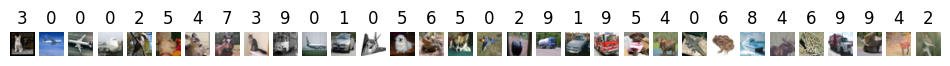

torch.Size([32, 3, 32, 32])


In [8]:
display_image(images)
print(images.shape)

**6. (5 pts) Make a class called `ConvolutionalNeuralNetwork()`, this class must inherit the methods from the parent class `nn.Module`, inside the class, create two methods called `__init__()` and `forward()`. Inside the `__init__()`, initialize all the appropriate variables or building blocks of a CNN architecture. Inside the `forward()` method will be where the initialized building-block variables will be called for forward propagation. `THE FOLLOWING ARCHITECTURE WILL BE USED`.**

<center><img src="cnn_architecture.png"></center>

In [9]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        

        self.fc1 = nn.Linear(in_features=64 * 4 * 4, out_features=128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        x = x.view(x.size(0), -1) 
        
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.softmax(x)
        
        return x

**7. (3 pts) Initialize the model, and count the number of parameters (weights and biases).**

In [10]:
model = ConvolutionalNeuralNetwork()
model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [11]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

  2400
    32
 25600
    32
 51200
    64
131072
   128
  1280
    10
______
211818


**8. (3 pts) Initialize `optimizer` and `criterion` functions. Use `SGD` as optimizer with a learning rate of `0.001`, and `CrossEntropyLoss` as criterion.`**

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

**BONUS (2 pts): Make a function that sets the device of the training process to the available compute device (cpu or cuda).**

If you are using a GPU, you can move the model to that device.

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

model = model.to(device)

cpu


**9. (5 pts) Create the training loop for PyTorch, train your model for 10 epochs, and print the interim results four times per epoch.**

In [14]:
set_seed(143)
epochs = 10
start_time = time.time()
best_acc = 0.0

train_correct = []
train_losses = []
train_accs = []

val_correct = []
val_losses = []
val_accs = []

for e in range(epochs):
    train_corr = 0
    val_corr = 0
    
    for train_b, (x_train, y_train) in tqdm(enumerate(train_loader)):
        train_b += 1
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        train_pred = model(x_train)
        train_loss = criterion(train_pred, y_train)

        train_pred_vec = torch.max(train_pred.data, 1)[1] # prediction vector
        train_corr += (train_pred_vec == y_train).sum()

        # Update parameters
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if train_b % (len(train_loader) // 4) == 0:  # Print every quarter of the batches
            print(f"epoch: {e+1:2} | batch: {train_b:4} | instances: [{train_b*batch_size:6} / {len(train_loader)  * batch_size}] | loss: {train_loss.item()}")
            print(f"✅{train_corr.item()} of {train_b*batch_size:2} | accuracy: {round(((train_corr.item() / (train_b*batch_size))) * 100 , 3)}%")

        train_correct.append(train_corr.item())
        train_losses.append(train_loss.item())

    with torch.no_grad():
        for val_b, (x_val, y_val) in enumerate(val_loader):
            val_b += 1
            
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            val_pred = model(x_val)
            val_pred_vec = torch.max(val_pred.data, 1)[1]
            val_corr += (val_pred_vec == y_val).sum()

            val_loss = criterion(val_pred, y_val)
            val_correct.append(val_corr.item())
            val_losses.append(val_loss.item())
            
            val_acc = val_corr.item() / (len(val_loader) * batch_size)
            
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"model/best_{model._get_name()}.pth")
            print(f"\t📁New best model saved! | accuracy: {best_acc*100}%")
    
    train_epoch_acc = train_corr.item() / (batch_size * len(train_loader))
    val_epoch_acc = val_corr.item() / (batch_size * len(val_loader))
    
    train_accs.append(train_epoch_acc)
    val_accs.append(val_epoch_acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

0it [00:00, ?it/s]

epoch:  1 | batch:  312 | instances: [  9984 / 40000] | loss: 2.3012027740478516
✅975 of 9984 | accuracy: 9.766%
epoch:  1 | batch:  624 | instances: [ 19968 / 40000] | loss: 2.302436590194702
✅2003 of 19968 | accuracy: 10.031%
epoch:  1 | batch:  936 | instances: [ 29952 / 40000] | loss: 2.3033058643341064
✅2999 of 29952 | accuracy: 10.013%
epoch:  1 | batch: 1248 | instances: [ 39936 / 40000] | loss: 2.3028316497802734
✅3993 of 39936 | accuracy: 9.998%
	📁New best model saved! | accuracy: 9.994009584664537%


0it [00:00, ?it/s]

epoch:  2 | batch:  312 | instances: [  9984 / 40000] | loss: 2.302258014678955
✅1021 of 9984 | accuracy: 10.226%
epoch:  2 | batch:  624 | instances: [ 19968 / 40000] | loss: 2.302586793899536
✅2021 of 19968 | accuracy: 10.121%
epoch:  2 | batch:  936 | instances: [ 29952 / 40000] | loss: 2.301638126373291
✅2981 of 29952 | accuracy: 9.953%
epoch:  2 | batch: 1248 | instances: [ 39936 / 40000] | loss: 2.3018057346343994
✅3993 of 39936 | accuracy: 9.998%


0it [00:00, ?it/s]

epoch:  3 | batch:  312 | instances: [  9984 / 40000] | loss: 2.3021998405456543
✅1027 of 9984 | accuracy: 10.286%
epoch:  3 | batch:  624 | instances: [ 19968 / 40000] | loss: 2.301417350769043
✅2020 of 19968 | accuracy: 10.116%
epoch:  3 | batch:  936 | instances: [ 29952 / 40000] | loss: 2.3016912937164307
✅3005 of 29952 | accuracy: 10.033%
epoch:  3 | batch: 1248 | instances: [ 39936 / 40000] | loss: 2.3032710552215576
✅3993 of 39936 | accuracy: 9.998%


0it [00:00, ?it/s]

epoch:  4 | batch:  312 | instances: [  9984 / 40000] | loss: 2.3021483421325684
✅1004 of 9984 | accuracy: 10.056%
epoch:  4 | batch:  624 | instances: [ 19968 / 40000] | loss: 2.303022623062134
✅2020 of 19968 | accuracy: 10.116%
epoch:  4 | batch:  936 | instances: [ 29952 / 40000] | loss: 2.302886962890625
✅2994 of 29952 | accuracy: 9.996%
epoch:  4 | batch: 1248 | instances: [ 39936 / 40000] | loss: 2.301363945007324
✅3992 of 39936 | accuracy: 9.996%


0it [00:00, ?it/s]

epoch:  5 | batch:  312 | instances: [  9984 / 40000] | loss: 2.3030636310577393
✅954 of 9984 | accuracy: 9.555%
epoch:  5 | batch:  624 | instances: [ 19968 / 40000] | loss: 2.3018298149108887
✅1967 of 19968 | accuracy: 9.851%
epoch:  5 | batch:  936 | instances: [ 29952 / 40000] | loss: 2.302851915359497
✅3013 of 29952 | accuracy: 10.059%
epoch:  5 | batch: 1248 | instances: [ 39936 / 40000] | loss: 2.301820755004883
✅3992 of 39936 | accuracy: 9.996%


0it [00:00, ?it/s]

epoch:  6 | batch:  312 | instances: [  9984 / 40000] | loss: 2.3032214641571045
✅999 of 9984 | accuracy: 10.006%
epoch:  6 | batch:  624 | instances: [ 19968 / 40000] | loss: 2.3012266159057617
✅1993 of 19968 | accuracy: 9.981%
epoch:  6 | batch:  936 | instances: [ 29952 / 40000] | loss: 2.303715229034424
✅2961 of 29952 | accuracy: 9.886%
epoch:  6 | batch: 1248 | instances: [ 39936 / 40000] | loss: 2.3009328842163086
✅3987 of 39936 | accuracy: 9.983%


0it [00:00, ?it/s]

epoch:  7 | batch:  312 | instances: [  9984 / 40000] | loss: 2.304349899291992
✅988 of 9984 | accuracy: 9.896%
epoch:  7 | batch:  624 | instances: [ 19968 / 40000] | loss: 2.3028600215911865
✅2007 of 19968 | accuracy: 10.051%
epoch:  7 | batch:  936 | instances: [ 29952 / 40000] | loss: 2.303194284439087
✅2992 of 29952 | accuracy: 9.989%
epoch:  7 | batch: 1248 | instances: [ 39936 / 40000] | loss: 2.3029978275299072
✅3991 of 39936 | accuracy: 9.993%


0it [00:00, ?it/s]

epoch:  8 | batch:  312 | instances: [  9984 / 40000] | loss: 2.3029043674468994
✅980 of 9984 | accuracy: 9.816%
epoch:  8 | batch:  624 | instances: [ 19968 / 40000] | loss: 2.30318546295166
✅1995 of 19968 | accuracy: 9.991%
epoch:  8 | batch:  936 | instances: [ 29952 / 40000] | loss: 2.302992105484009
✅2979 of 29952 | accuracy: 9.946%
epoch:  8 | batch: 1248 | instances: [ 39936 / 40000] | loss: 2.3026046752929688
✅3988 of 39936 | accuracy: 9.986%


0it [00:00, ?it/s]

epoch:  9 | batch:  312 | instances: [  9984 / 40000] | loss: 2.302966833114624
✅1014 of 9984 | accuracy: 10.156%
epoch:  9 | batch:  624 | instances: [ 19968 / 40000] | loss: 2.303586721420288
✅2010 of 19968 | accuracy: 10.066%
epoch:  9 | batch:  936 | instances: [ 29952 / 40000] | loss: 2.2997002601623535
✅2989 of 29952 | accuracy: 9.979%
epoch:  9 | batch: 1248 | instances: [ 39936 / 40000] | loss: 2.302814483642578
✅3995 of 39936 | accuracy: 10.004%


0it [00:00, ?it/s]

epoch: 10 | batch:  312 | instances: [  9984 / 40000] | loss: 2.3009870052337646
✅1002 of 9984 | accuracy: 10.036%
epoch: 10 | batch:  624 | instances: [ 19968 / 40000] | loss: 2.301626205444336
✅1997 of 19968 | accuracy: 10.001%
epoch: 10 | batch:  936 | instances: [ 29952 / 40000] | loss: 2.303708791732788
✅3018 of 29952 | accuracy: 10.076%
epoch: 10 | batch: 1248 | instances: [ 39936 / 40000] | loss: 2.3020176887512207
✅3996 of 39936 | accuracy: 10.006%

Duration: 491 seconds


**10. (3pts) Plot accuracy and loss per epoch, and make an assessment.**

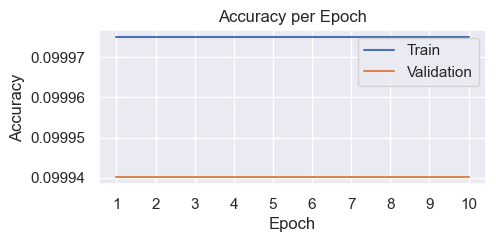

In [41]:
plt.figure(figsize=(5,2))
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.xticks(ticks=range(0,10), labels=list(range(1,11)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

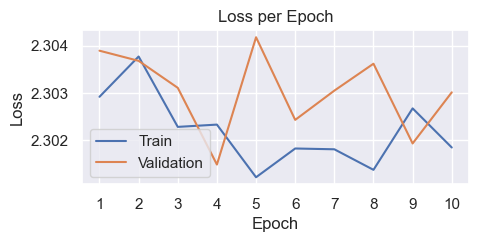

In [26]:
plt.figure(figsize=(5,2))
plt.plot([train_losses[i-1] for i in range(1250, len(train_losses)+1, 1250)], label="Train")
plt.plot([val_losses[i-1] for i in range(313, len(val_losses)+1, 313)], label="Validation")
plt.xticks(ticks=range(0,10), labels=list(range(1,11)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

**11. (3 pts) Create another instance of the `ConvolutionalNeuralNetwork()` class, name it `model2`, this time you must change the optimizer to `Adam` with the same learning rate of 0.001.**

In [17]:
model2 = ConvolutionalNeuralNetwork()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

**12. (5 pts) Train `model2` with `Adam` as optimizer for 10 epochs, and print the interim results four times per epoch.**

In [18]:
set_seed(143)
epochs = 10
start_time = time.time()
best_acc2 = 0.0

train_correct2 = []
train_losses2 = []
train_accs2 = []

val_correct2 = []
val_losses2 = []
val_accs2 = []

for e in range(epochs):
    train_corr = 0
    val_corr = 0
    
    for train_b, (x_train, y_train) in tqdm(enumerate(train_loader)):
        train_b += 1
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        train_pred = model2(x_train)
        train_loss = criterion(train_pred, y_train)

        train_pred_vec = torch.max(train_pred.data, 1)[1] # prediction vector
        train_corr += (train_pred_vec == y_train).sum()

        # Update parameters
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if train_b % (len(train_loader) // 4) == 0:
            progress = (train_b / len(train_loader)) * 100
            print(f"epoch: {e+1:2} | batch: {train_b:4} | progress: {progress:.1f}% | loss: {train_loss.item():.4f}")
            print(f"✅{train_corr.item()} of {train_b * batch_size:2} | accuracy: {round(((train_corr.item() / (train_b * batch_size))) * 100 , 3)}%")

        train_correct2.append(train_corr.item())
        train_losses2.append(train_loss.item())

    with torch.no_grad():
        for val_b, (x_val, y_val) in enumerate(val_loader):
            val_b += 1
            
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            val_pred = model2(x_val)
            val_pred_vec = torch.max(val_pred.data, 1)[1]
            val_corr += (val_pred_vec == y_val).sum()

            val_loss = criterion(val_pred, y_val)
            val_correct2.append(val_corr.item())
            val_losses2.append(val_loss.item())
            
            val_acc = val_corr.item() / (len(val_loader) * batch_size)
            
        if val_acc > best_acc2:
            best_acc2 = val_acc
            torch.save(model2.state_dict(), f"model/best_{model2._get_name()}.pth")
            print(f"\t📁New best model saved! | accuracy: {best_acc2 * 100:.2f}%")
    
    train_epoch_acc = train_corr.item() / (batch_size * len(train_loader))
    val_epoch_acc = val_corr.item() / (batch_size * len(val_loader))
    
    train_accs2.append(train_epoch_acc)
    val_accs2.append(val_epoch_acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

0it [00:00, ?it/s]

epoch:  1 | batch:  312 | progress: 25.0% | loss: 2.2712
✅2015 of 9984 | accuracy: 20.182%
epoch:  1 | batch:  624 | progress: 49.9% | loss: 2.2741
✅4658 of 19968 | accuracy: 23.327%
epoch:  1 | batch:  936 | progress: 74.9% | loss: 2.0128
✅7784 of 29952 | accuracy: 25.988%
epoch:  1 | batch: 1248 | progress: 99.8% | loss: 2.0647
✅11110 of 39936 | accuracy: 27.82%
	📁New best model saved! | accuracy: 36.17%


0it [00:00, ?it/s]

epoch:  2 | batch:  312 | progress: 25.0% | loss: 2.1192
✅3687 of 9984 | accuracy: 36.929%
epoch:  2 | batch:  624 | progress: 49.9% | loss: 2.1642
✅7484 of 19968 | accuracy: 37.48%
epoch:  2 | batch:  936 | progress: 74.9% | loss: 2.0760
✅11462 of 29952 | accuracy: 38.268%
epoch:  2 | batch: 1248 | progress: 99.8% | loss: 2.1197
✅15614 of 39936 | accuracy: 39.098%
	📁New best model saved! | accuracy: 41.84%


0it [00:00, ?it/s]

epoch:  3 | batch:  312 | progress: 25.0% | loss: 1.9987
✅4254 of 9984 | accuracy: 42.608%
epoch:  3 | batch:  624 | progress: 49.9% | loss: 1.9305
✅8593 of 19968 | accuracy: 43.034%
epoch:  3 | batch:  936 | progress: 74.9% | loss: 1.8609
✅13059 of 29952 | accuracy: 43.6%
epoch:  3 | batch: 1248 | progress: 99.8% | loss: 2.0072
✅17622 of 39936 | accuracy: 44.126%
	📁New best model saved! | accuracy: 44.50%


0it [00:00, ?it/s]

epoch:  4 | batch:  312 | progress: 25.0% | loss: 2.0238
✅4671 of 9984 | accuracy: 46.785%
epoch:  4 | batch:  624 | progress: 49.9% | loss: 1.9626
✅9455 of 19968 | accuracy: 47.351%
epoch:  4 | batch:  936 | progress: 74.9% | loss: 1.9690
✅14346 of 29952 | accuracy: 47.897%
epoch:  4 | batch: 1248 | progress: 99.8% | loss: 1.9161
✅19338 of 39936 | accuracy: 48.422%
	📁New best model saved! | accuracy: 50.19%


0it [00:00, ?it/s]

epoch:  5 | batch:  312 | progress: 25.0% | loss: 1.9749
✅5035 of 9984 | accuracy: 50.431%
epoch:  5 | batch:  624 | progress: 49.9% | loss: 2.0887
✅10209 of 19968 | accuracy: 51.127%
epoch:  5 | batch:  936 | progress: 74.9% | loss: 2.0637
✅15316 of 29952 | accuracy: 51.135%
epoch:  5 | batch: 1248 | progress: 99.8% | loss: 1.9288
✅20469 of 39936 | accuracy: 51.255%
	📁New best model saved! | accuracy: 52.20%


0it [00:00, ?it/s]

epoch:  6 | batch:  312 | progress: 25.0% | loss: 1.9223
✅5323 of 9984 | accuracy: 53.315%
epoch:  6 | batch:  624 | progress: 49.9% | loss: 1.8805
✅10652 of 19968 | accuracy: 53.345%
epoch:  6 | batch:  936 | progress: 74.9% | loss: 1.7801
✅16033 of 29952 | accuracy: 53.529%
epoch:  6 | batch: 1248 | progress: 99.8% | loss: 1.8745
✅21357 of 39936 | accuracy: 53.478%
	📁New best model saved! | accuracy: 54.16%


0it [00:00, ?it/s]

epoch:  7 | batch:  312 | progress: 25.0% | loss: 1.9389
✅5541 of 9984 | accuracy: 55.499%
epoch:  7 | batch:  624 | progress: 49.9% | loss: 1.8414
✅10906 of 19968 | accuracy: 54.617%
epoch:  7 | batch:  936 | progress: 74.9% | loss: 1.7697
✅16460 of 29952 | accuracy: 54.955%
epoch:  7 | batch: 1248 | progress: 99.8% | loss: 1.9897
✅22077 of 39936 | accuracy: 55.281%
	📁New best model saved! | accuracy: 55.82%


0it [00:00, ?it/s]

epoch:  8 | batch:  312 | progress: 25.0% | loss: 1.8674
✅5731 of 9984 | accuracy: 57.402%
epoch:  8 | batch:  624 | progress: 49.9% | loss: 1.8014
✅11361 of 19968 | accuracy: 56.896%
epoch:  8 | batch:  936 | progress: 74.9% | loss: 1.9215
✅17047 of 29952 | accuracy: 56.914%
epoch:  8 | batch: 1248 | progress: 99.8% | loss: 1.9739
✅22786 of 39936 | accuracy: 57.056%


0it [00:00, ?it/s]

epoch:  9 | batch:  312 | progress: 25.0% | loss: 1.8321
✅5806 of 9984 | accuracy: 58.153%
epoch:  9 | batch:  624 | progress: 49.9% | loss: 1.8348
✅11667 of 19968 | accuracy: 58.428%
epoch:  9 | batch:  936 | progress: 74.9% | loss: 1.8396
✅17561 of 29952 | accuracy: 58.63%
epoch:  9 | batch: 1248 | progress: 99.8% | loss: 1.9724
✅23380 of 39936 | accuracy: 58.544%
	📁New best model saved! | accuracy: 56.41%


0it [00:00, ?it/s]

epoch: 10 | batch:  312 | progress: 25.0% | loss: 2.0138
✅5990 of 9984 | accuracy: 59.996%
epoch: 10 | batch:  624 | progress: 49.9% | loss: 1.9870
✅12005 of 19968 | accuracy: 60.121%
epoch: 10 | batch:  936 | progress: 74.9% | loss: 1.8526
✅17893 of 29952 | accuracy: 59.739%
epoch: 10 | batch: 1248 | progress: 99.8% | loss: 1.8199
✅23850 of 39936 | accuracy: 59.721%
	📁New best model saved! | accuracy: 56.95%

Duration: 517 seconds


**13. (3 pts) Plot accuracy and loss per epoch, and make an assessment. Compare the `model` and the `model2`'s results.**

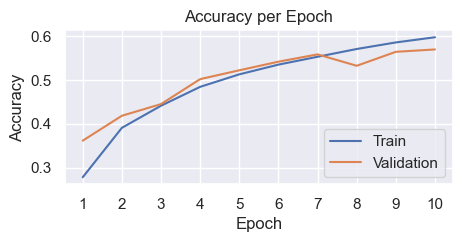

In [27]:
plt.figure(figsize=(5, 2))
plt.plot(train_accs2, label="Train")
plt.plot(val_accs2, label="Validation")
plt.xticks(ticks=range(0, 10), labels=list(range(1, 11)))  # Set ticks and labels for 10 epochs
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

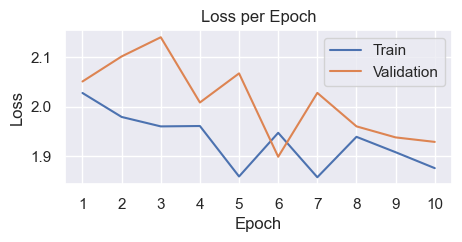

In [39]:
plt.figure(figsize=(5,2))
plt.plot([train_losses2[i-1] for i in range(1250, len(train_losses2)+1, 1250)], label="Train")
plt.plot([val_losses2[i-1] for i in range(313, len(val_losses2)+1, 313)], label="Validation")
plt.xticks(ticks=range(0,10), labels=list(range(1,11)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()